In [0]:
!pip install mxnet-cu100

#MXNet (Using Gluon)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

##First we need to understand how to do convolution in gluon 

####Getting a sample image from web

In [0]:
import urllib.request
urllib.request.urlretrieve('https://i.stack.imgur.com/B2DBy.jpg', 'B2DBy.jpg')

('B2DBy.jpg', <http.client.HTTPMessage at 0x7f3ef8c64240>)

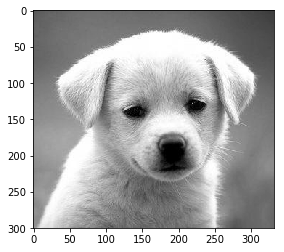

(300, 332, 1)
(1, 300, 332)
(1, 1, 300, 332)


In [0]:
image = mx.image.imread('B2DBy.jpg', flag = 0).astype('float32').as_in_context(mx.gpu())
# flag = 0 to get grayscale image with channel 1, flag = 1 to get coloured image with channel 3
# this time we are not using .flatten() to load the image,
# because we need number of channels (1 in this case) in order to feed the image to gluon cnn layer.

plt.imshow(image.flatten().asnumpy(), cmap = 'gray')
plt.show()

print(image.shape)

image = nd.moveaxis(image, 2, 0)
# converting image shape to channel first format,
# because gluon cnn works much faster with this layout,
# so by default mxnet gluon uses layout = "NCHW" (No of images, No of of channels, Hight, Width)
# Althout you can set layout to "NHWC" if you want to feed image with channel last layout
print(image.shape)

image = image.expand_dims(0)
# expand_dims adds 1 more dimention to the provide axis.
# SO WHY ARE WE DOING THAT??
# Because gluon layers takes argument with shape (batch_size, *shape of image(in Either NCHW(which is default) or NHWC(which you need to set))).
# and in our case batch_size is 1(as we have only one image for this example)
print(image.shape)

In [0]:
conv = nn.Conv2D(channels = 1, kernel_size = (3, 3))
conv.initialize(mx.init.Xavier(), ctx = mx.gpu())
# channels = 1 means that we would like to get channel 1 for output.
# so output shape would be like (batch_size, channels, hight, width)
# think of channels as no of kernels we want to have. (yes, no of kernels determines how many channels next layer would have.)
# for n no of kernels we would have n no of channels in next layer

###Now lets run this conv layer on our image

(1, 1, 298, 330)

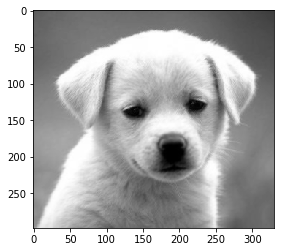

In [0]:
output = conv(image)

plt.imshow(output[0][0].asnumpy(), cmap = 'gray')

output.shape
# as we passed channels 1 hence we get shape as below. (==, channels, ==, ==)

In [0]:
# now lets try channels 3
conv = nn.Conv2D(channels = 3, kernel_size = (3, 3))
conv.initialize(mx.init.Xavier(), ctx = mx.gpu())

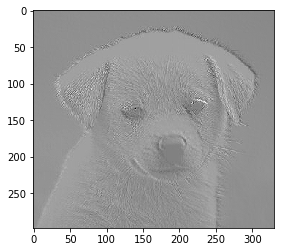

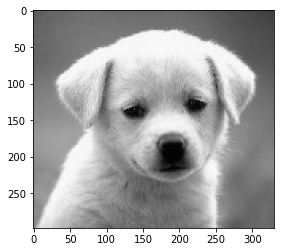

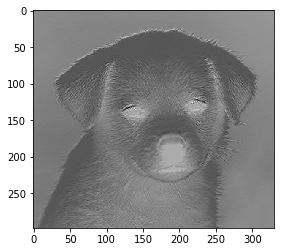

(1, 3, 298, 330)

In [0]:
output = conv(image)

plt.imshow(output[0][0].asnumpy(), cmap = 'gray')
plt.show()
plt.imshow(output[0][1].asnumpy(), cmap = 'gray')
plt.show()
plt.imshow(output[0][2].asnumpy(), cmap = 'gray')
plt.show()
# since we passed 3 channels so it will generate 3 random filters instead of 1.
# and return 3 "convoluted" images. so no of channel output will be 3.

output.shape
# as we passed channels 3 hence we will get 3 channels in output layer.

###So now we understand how to create single layer of cnn in gluon, lets create a model filled with stack of cnn layers.

###But first lets get our data

In [0]:
def transform(data, label):
    return data.swapaxes(0, 2).astype('float32')/255.0, label.astype('float32')

train_cifar = gluon.data.vision.CIFAR10(train = True, transform = transform)
test_cifar = gluon.data.vision.CIFAR10(train = False, transform = transform)

In [0]:
classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [0]:
image, label = train_cifar[456]
print(image.shape, label.shape)

(3, 32, 32) ()


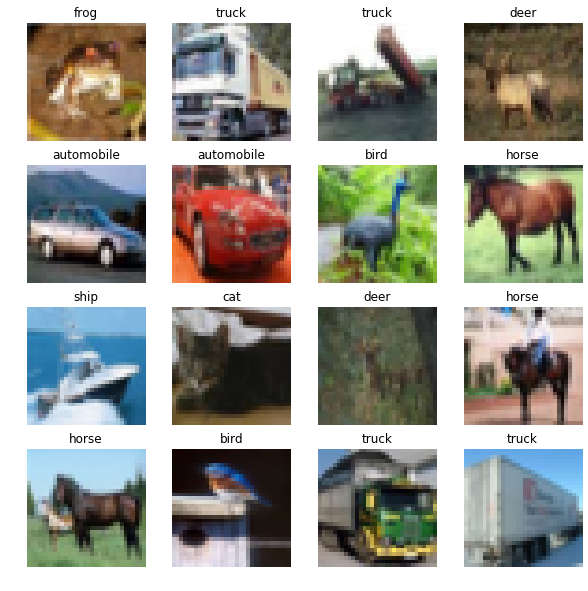

In [0]:
# we need to swap axes because matplotlib accepts image with layout NHWC not NCHW
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(train_cifar[i][0].swapaxes(0, 2).asnumpy())
    plt.title(classes[train_cifar[i][1]])
    plt.axis('off')
plt.show()
# the images might look like bad and blurry, but its perfect for a deep learning models.

##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_cifar, batch_size = batch_size, shuffle = True)
testing_data = gluon.data.DataLoader(test_cifar, batch_size = batch_size, shuffle = False)

##Building the model

In [0]:
model = nn.HybridSequential()
model.add(nn.Conv2D(channels = 32, kernel_size = 3, activation = 'relu'))
model.add(nn.AvgPool2D())
model.add(nn.Conv2D(channels = 64, kernel_size = 3, activation = 'relu'))
model.add(nn.AvgPool2D())
model.add(nn.Conv2D(channels = 128, kernel_size = 3, activation = 'relu'))
model.add(nn.AvgPool2D())
model.add(nn.Flatten())
model.add(nn.Dense(256, 'relu')) 
model.add(nn.Dropout(0.5))
model.add(nn.Dense(128, 'relu'))
model.add(nn.Dropout(0.5))
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), mx.gpu())
model.hybridize()

In [0]:
model

HybridSequential(
  (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (1): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=avg, layout=NCHW)
  (2): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (3): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=avg, layout=NCHW)
  (4): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1), Activation(relu))
  (5): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=avg, layout=NCHW)
  (6): Flatten
  (7): Dense(None -> 256, Activation(relu))
  (8): Dropout(p = 0.5, axes=())
  (9): Dense(None -> 128, Activation(relu))
  (10): Dropout(p = 0.5, axes=())
  (11): Dense(None -> 10, linear)
)

In [0]:
model(image.expand_dims(0).as_in_context(mx.gpu()))

##Defining our objective function

In [0]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()

##Defining our parameters optimizer

In [0]:
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

##Defining our accuracy function

In [0]:
metric = mx.metric.Accuracy()

##Training the  model

In [0]:
epochs = 10
losses = []
accs = []
import time

start = time.time()
for epoch in range(epochs):
    batch_begin = time.time()
    cumulative_loss = 0
    metric.reset()
    for batches, (features, labels) in enumerate(training_data, 1):
        features = features.as_in_context(mx.gpu())
        labels = labels.as_in_context(mx.gpu())
        with autograd.record():
            output = model(features)
            loss = objective(output, labels)
        loss.backward()
        optimizer.step(batch_size)
        cumulative_loss += loss.mean()
        metric.update(labels, output)
    acc = metric.get()[1]
    losses.append(cumulative_loss.asscalar())
    accs.append(acc)
    print(f'Epoch: {epoch} | Loss: {cumulative_loss.asscalar()/(batches):.5f} | Accuracy: {acc:.5f}')
    print(f'Took: {time.time() - batch_begin}')
print(f'Total time taken: {time.time() - start}')

Epoch: 0 | Loss: 1.79907 | Accuracy: 0.32098
Took: 20.753207206726074
Epoch: 1 | Loss: 1.43864 | Accuracy: 0.47758
Took: 20.90489411354065
Epoch: 2 | Loss: 1.27667 | Accuracy: 0.54614
Took: 20.894549131393433
Epoch: 3 | Loss: 1.16699 | Accuracy: 0.58938
Took: 20.986249446868896
Epoch: 4 | Loss: 1.07003 | Accuracy: 0.62618
Took: 21.11782956123352
Epoch: 5 | Loss: 0.99398 | Accuracy: 0.65140
Took: 21.113565921783447
Epoch: 6 | Loss: 0.94053 | Accuracy: 0.67454
Took: 21.362778186798096
Epoch: 7 | Loss: 0.88670 | Accuracy: 0.69554
Took: 21.157837390899658
Epoch: 8 | Loss: 0.83836 | Accuracy: 0.71244
Took: 21.27980351448059
Epoch: 9 | Loss: 0.80252 | Accuracy: 0.72690
Took: 21.383868932724
Total time taken: 210.95790266990662


##Lets see test accuracy

In [0]:
metric.reset()
for features, labels in testing_data:
    features = features.as_in_context(mx.gpu())
    labels = labels.as_in_context(mx.gpu())
    predictions = model(features)
    metric.update(labels, predictions)
print(f'Test Accuracy: {metric.get()[1]:.5f}')

In [0]:
def plot(losses = losses, accs = accs, model = model):
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    fig = plt.figure(figsize = (15, 15))

    for i in range(16):
        features, labels = test_cifar[i]
        features = features.as_in_context(mx.gpu()).expand_dims(0)
        pred = model(features).argmax(1).asscalar()
        fig.add_subplot(4, 4, i + 1)
        plt.imshow(features[0].swapaxes(0, 2).asnumpy())
        plt.title(f'Target: {classes[labels]}, Predicted: {classes[pred]}')
        plt.axis('off')
    plt.show()

In [0]:
plot()